### Consensus meta-analysis



In [1]:
import os,glob
import numpy
import nibabel
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import pandas 
from statsmodels.stats.multitest import multipletests
#from utils import t_corr
import scipy.stats
from narps import Narps,NarpsDirs

%matplotlib inline

# set an environment variable called NARPS_BASEDIR with location of base directory
if 'NARPS_BASEDIR' in os.environ:
    basedir = os.environ['NARPS_BASEDIR']
else:
    basedir = '/data'
assert os.path.exists(basedir)

narps = Narps(basedir,overwrite=False)
narps.load_data()

orig_dir = os.path.join(basedir,'orig')
metadata_dir = os.path.join(basedir,'metadata')
output_dir = narps.dirs.dirs['output']
figure_dir = os.path.join(basedir,'figures')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)
template_img = narps.dirs.MNI_template
mask_img = narps.dirs.MNI_mask

figure_dir = os.path.join(basedir,'figures')
results_dir = os.path.join(output_dir,'1sample_ttest')

if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
overwrite = False

/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


found 54 input directories
found 54 teams with complete original datasets


In [2]:
def t_corr(y,res_mean=None,res_var=None,Q=None):
    """
    perform a one-sample t-test on correlated data
    y = data (n observations X n vars)
    res_mean = Common mean over voxels and results
    res_var  = Common variance over voxels and results
    Q = "known" correlation across observations (use empirical correlation based on maps)
    """
    
    # Jeanette:
    # This paper calculates the df for an F-test, so the chisquare bit we need is in there.  Your t-statistic will come from
    # X = column of 1's (design matrix)

    npts = y.shape[0]
    X = numpy.ones((npts,1))

    if res_mean is None:
        res_mean = 0

    if res_var is None:
        res_var = 1
  
    if Q is None:
        Q = numpy.eye(npts)

    # R = I{n} - X(X'X)^{-1}X'
    R = numpy.eye(npts) - X.dot(numpy.linalg.inv(X.T.dot(X))).dot(X.T)

    
    VarMean = res_var * X.T.dot(Q).dot(X) / npts**2

    # T  =  mean(y,0)/s-hat-2
    # use diag to get s_hat2 for each variable 
    T = (numpy.mean(y,0)-res_mean)/numpy.sqrt(VarMean)*numpy.sqrt(res_var) + res_mean

    # # *If* variance were estimated voxelwise on correlated data, the DF would follow 
    # # this expression = v = tr(RQ)^2/tr(RQRQ)
    # df = (numpy.trace(R.dot(Q))**2)/numpy.trace(R.dot(Q).dot(R).dot(Q))
    # p = 1 - scipy.stats.t.cdf(T,df=df)
    
    # Assuming variance is estimated on whole image
    df = numpy.Inf
    p  = 1 - scipy.stats.norm.cdf(T)
    
    return(T,df,p)


In [3]:
masker = nilearn.input_data.NiftiMasker(mask_img=mask_img)

for hyp in [1,2,5,6,7,8,9]:
    if os.path.exists(os.path.join(results_dir,'hypo%d_1-fdr.nii.gz'%hyp)) and not overwrite:
        print('using existing results')
        continue
    print('running ttests for hypothesis',hyp)
    maps = glob.glob(os.path.join(output_dir,'zstat/*/hypo%d_unthresh.nii.gz'%hyp))
    maps.sort()
    data = masker.fit_transform(maps)
    
    # get estimated mean, variance, and correlation for t_corr
    img_mean = numpy.mean(data)
    img_var = numpy.mean(numpy.var(data,1))
    cc=numpy.corrcoef(data)
    print(img_mean,img_var,numpy.mean(cc[numpy.triu_indices_from(cc,1)]))
    # perform t-test
    tvals = numpy.zeros(data.shape[1])
    pvals = numpy.zeros(data.shape[1])
    dfs = numpy.zeros(data.shape[1])
    tvals,dfs,pvals=t_corr(data,res_mean=img_mean,res_var=img_var,Q=cc)
    
    # move back into image format
    timg = masker.inverse_transform(tvals)
    timg.to_filename(os.path.join(results_dir,'hypo%d_t.nii.gz'%hyp))
    pimg = masker.inverse_transform(1-pvals)
    pimg.to_filename(os.path.join(results_dir,'hypo%d_1-p.nii.gz'%hyp))
    fdr_results = multipletests(pvals[0,:],0.05,'fdr_tsbh')
    print("%d voxels significant at FDR corrected p<.05"%numpy.sum(fdr_results[0]))
    fdrimg = masker.inverse_transform(1 - fdr_results[1])
    fdrimg.to_filename(os.path.join(results_dir,'hypo%d_1-fdr.nii.gz'%hyp))
    
    

    
    

using existing results
using existing results
using existing results
using existing results
using existing results
using existing results
using existing results


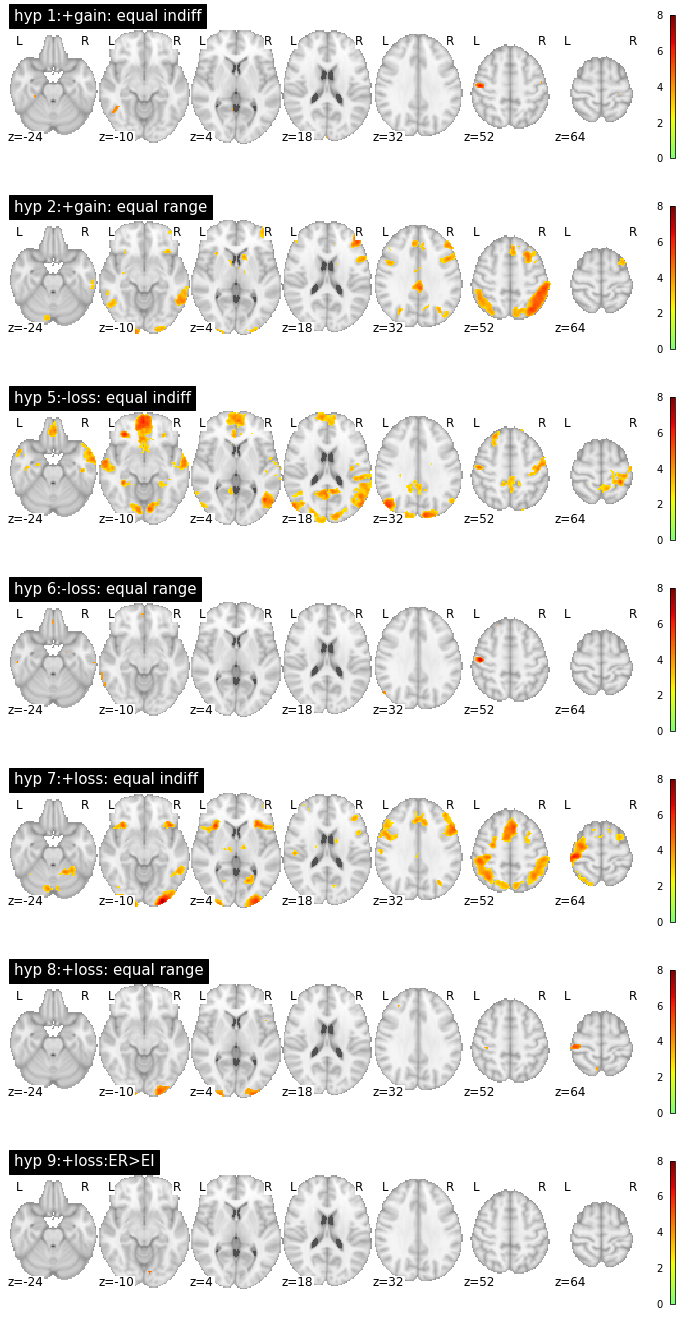

In [4]:


fig, ax = plt.subplots(7,1,figsize=(12,24))
thresh=0.95
hypnums=[1,2,5,6,7,8,9]
cut_coords = [-24,-10,4,18,32,52,64]
hypotheses= {1:'+gain: equal indiff',
            2:'+gain: equal range',
            5:'-loss: equal indiff',
            6:'-loss: equal range',
            7:'+loss: equal indiff',
            8:'+loss: equal range',
            9:'+loss:ER>EI'}

for i,hyp in enumerate(hypnums):
    pmap = os.path.join(output_dir,'1sample_ttest/hypo%d_1-fdr.nii.gz'%hyp)
    tmap =  os.path.join(output_dir,'1sample_ttest//hypo%d_t.nii.gz'%hyp)
    pimg = nibabel.load(pmap)
    timg = nibabel.load(tmap)
    pdata = pimg.get_fdata()
    tdata = timg.get_fdata()[:,:,:,0]
    threshdata = (pdata>thresh)*tdata
    threshimg = nibabel.Nifti1Image(threshdata,affine=timg.affine)
    nilearn.plotting.plot_stat_map(threshimg, threshold=0.1, display_mode="z", 
                colorbar=True,title='hyp %d:'%hyp+hypotheses[hyp],vmax=8,cmap='jet',
                                  cut_coords = cut_coords,axes = ax[i])

plt.savefig(os.path.join(figure_dir,'consensus_map.pdf'))


### TBD: run models with regressors for analysis features

Include the following regressors:
- was fmriprep used?
- was motion regression used?
- was confound regression (compcor or other) used?
- was a separate RT regressor used?



